In [8]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [9]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
import lightgbm
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import csv
import glob
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

## data shori

In [11]:
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|※|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|：|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [12]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

In [13]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])

df_ = pd.read_csv("summary_set_dokujo_it.tsv", 
#                 delimiter='\t', header=None, names=['summaries'])

#df_ = pd.read_csv("summary_set_dokujo_peachy.tsv", 
                 delimiter='\t', header=None, names=['summaries'])

In [14]:
labels = df.label.values
summaries = df_.summaries.values
labels.shape, summaries.shape

((1740,), (1740,))

In [17]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for summa in summaries:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(summa)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  72
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [18]:
input_ids = []
attention_masks = []

# 1文づつ処理
for summa in summaries:
    encoded_dict = tokenizer.encode_plus(
                        summa,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = 50,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', summaries[0])
print('Token IDs:', input_ids[0])

Original:  思いがけないことがある人間は、未来を教えてくれることがある。
Token IDs: tensor([    9,  2969,    12, 18143,  1272,   858,    11,     7,  3638, 15718,
        17379,  1272,     8,     2,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3])


In [19]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数：1540
検証データ数:　172 


In [20]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

2022-10-14 22:12:06.927972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 22:12:07.036540: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 22:12:07.395944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-14 22:12:07.395988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [22]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [23]:
# accuracy keisan

import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
        
print(statistics.mean(test_accuracy))

0.7048611111111112


In [24]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 3.7722, -4.2100],
        [-4.7970,  4.7886],
        [-4.5730,  4.7843],
        [ 0.4506, -0.5676],
        [-4.1807,  4.3323],
        [ 4.6500, -4.8177],
        [-4.7070,  4.7666],
        [-4.8782,  4.9630],
        [ 4.7773, -5.0688],
        [ 4.4903, -4.8129],
        [-4.7947,  4.9347],
        [ 0.5713, -0.3180]], device='cuda:0'), hidden_states=None, attentions=None)


In [25]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,3.772218,-4.209967,0,1
1,-4.797009,4.788573,1,1
2,-4.573005,4.784321,1,1
3,0.450601,-0.567594,0,1
4,-4.180709,4.332259,1,0


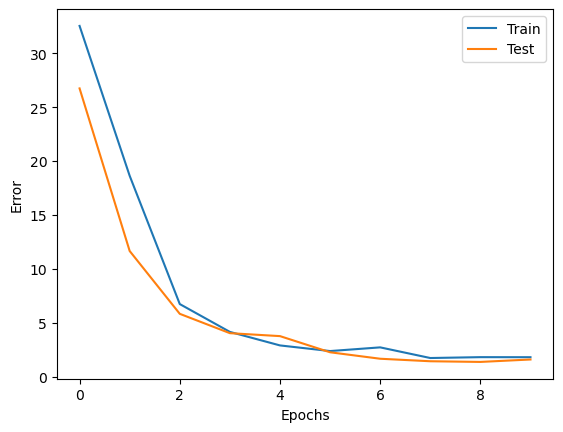

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと